# Load modules and data

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [73]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [74]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    df = df.drop("Age", axis = 1)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    df = df.drop("Fare", axis = 1)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    df = df.drop(["Name"], axis = 1)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

# Initial exploration

Lets take a quick overlook of the data

In [75]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We'll focus on two columns that we haven't used before during the Dataquest course: *SibSp* and *Parch*

*SibSp* is an integer representing the sum of siblings and/or spouses each passenger had aboard the Titanic

*Parch* is also an integer, representing the sum of parents and/or children each passenger had aboard the Titanic

In [76]:
relevant_features = ["SibSp", "Parch"]
train[relevant_features].describe()

,SibSp,Parch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


We can see that for both feature, the mean is between 0 and 1, which means that most of the passenger where on board alone. Also, by looking at the max, mean, and median values we can assume the distribution is skewed, with just a couple passengers having a high count of relatives on the ship

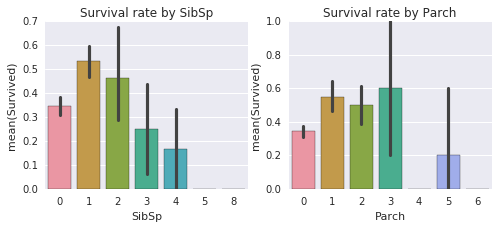

In [77]:
fig, axes = plt.subplots(1, 2, figsize = (8, 3))

sns.barplot("SibSp", "Survived", data = train, ax = axes[0])
axes[0].set_title("Survival rate by SibSp")

sns.barplot("Parch", "Survived", data = train, ax = axes[1])
axes[1].set_title("Survival rate by Parch")

From the graphic we can tell that having from 1 to 2 siblings/spouses, and/or 1 to 3 parents/childrens gives you a better chance at survival when compared to passengers that traveled alone or with bigger families.

Lets check this idea further by combining both features into one

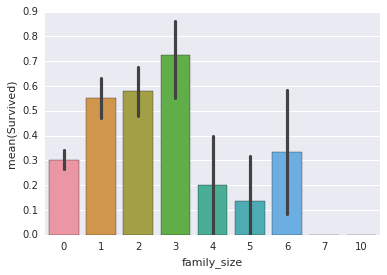

In [78]:
explore_cols = ["SibSp", "Parch", "Survived"]
explore = train[explore_cols].copy()
explore["family_size"] = explore[["SibSp", "Parch"]].sum(axis = 1)

sns.barplot("family_size", "Survived", data = explore)
axes[1].set_title("Survival rate by Family size")

As expected, passenger that traveled alone aboard the Titanic had about 30% chances of surviving the accident. This information will become useful when we engineer new features for the model

# Feature engineering

We have already developed and loaded a series of functions to clean our initial data and engineer some new features. Before applying those to our data sets, lets developed a new feature based on a passenger family size

In [79]:
def process_family_size(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis = 1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

In [80]:
def process_dataframe(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, "Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df, "Title")
    df = create_dummies(df, "Cabin_type")
    df = create_dummies(df, "Sex")
    df = process_family_size(df)
    return df

In [81]:
train = process_dataframe(train)
test = process_dataframe(test)

We know that dummy columns have a risk of being multicollinear, so we will drop some of the features in order to reduce this phenomenon and prevent overfitting of our model 

In [82]:
drop_cols = ["Sex_male", "Age_categories_Missing", "Cabin_type_Unknown", "Fare_categories_100+"]
train = train.drop(drop_cols, axis = 1)
test = test.drop(drop_cols, axis = 1)

We also want to remove the *SibSp* and the *Parch* columns since we joint the data from those features into the *isalone* column

In [83]:
drop_cols = ["SibSp", "Parch"]
train = train.drop(drop_cols, axis = 1)
test = test.drop(drop_cols, axis = 1)

# Feature selection

Feature selection
In order to choose an optimal set of features for our model we will be using a Recursive Feature Elimination method with Cross-Validation. The initial feature weights will be given by a Random Forest Classifier model

In [84]:
def select_features(df):
    df = df.select_dtypes(["number"]).dropna(axis = 1)
    all_X = df.drop(["Survived", "PassengerId"], axis = 1)
    all_y = df["Survived"]
    rfc = RandomForestClassifier(random_state = 1)
    selector = RFECV(rfc, cv = 10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    
    print(optimized_columns)
    return optimized_columns

In [85]:
optimized_columns = select_features(train)

Index(['Pclass', 'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E', 'Sex_female', 'isalone'],
      dtype='object')


The list of selected columns looks a little bit odd. We would expect strong correlation between the titles of "Mr.", "Miss" and "Mrs." and the gender of a passenger, specifically because this data considers binary genres. It's also reasonable to expect that first class passengers paid more for their tickets, so there will be significant correlation between Fares and passenger class. 

Lets confirm our suspicions with a heatmap of feature correlations:

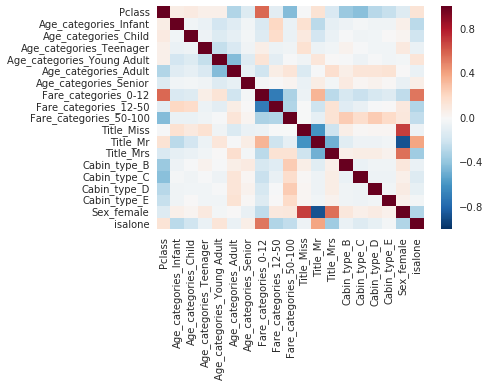

In [86]:
sns.heatmap(train[optimized_columns].corr())

As expected, the plot shows some of the strong correlations that we predicted. It also shows a strong correlation between the *isalone* feature and *Pclass*, which means that most of the lone passengers travelled in third class. We will decline from removing possibly redundant features from the model, understanding that it might become too overfit

# Model selection and hyperparameter optimization

We'll use a Grid Search algorithm to find the best combination of hyperparameters for three different models: Logistic Regression, K-Nearest Neighbors and Random Forest

In [87]:
lr_dict = {
    "name": "LogisticRegression",
    "estimator": LogisticRegression(),
    "hyperparameters":
    {
        "solver": ["newton-cg", "lbfgs", "liblinear"]
    }
}

knn_dict = {
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
    {
        "n_neighbors": range(1, 20, 2),
        "weights": ["distance", "uniform"],
        "algorithm": ["ball_tree", "kd_tree", "brute"],
        "p": [1, 2]
    }
}

rf_dict = {
    "name": "RandomForestClassifier",
    "estimator": RandomForestClassifier(random_state = 1),
    "hyperparameters":
    {
        "n_estimators": [4, 6, 9],
        "criterion": ["entropy", "gini"],
        "max_depth": [2, 5, 10],
        "max_features": ["log2", "sqrt"],
        "min_samples_leaf": [1, 5, 8],
        "min_samples_split": [2, 3, 5]
    }
}

dicts = [lr_dict, knn_dict, rf_dict]

In [88]:
def select_model(df, feature_cols, dicts):
    all_X = df[feature_cols]
    all_y = df["Survived"]
    
    for dict_ in dicts:
        print(dict_["name"])
        grid = GridSearchCV(dict_["estimator"], param_grid = dict_["hyperparameters"], cv = 10)
        grid.fit(all_X, all_y)
        best_params = grid.best_params_
        best_score = grid.best_score_
        dict_["best_params"] = best_params
        dict_["best_score"] = best_score
        dict_["best_estimator"] = grid.best_estimator_
        print(best_params)
        print(best_score)
    return dicts    

In [89]:
best_models = select_model(train, optimized_columns, dicts)

LogisticRegression
{'solver': 'newton-cg'}
0.81593714927
KNeighborsClassifier
{'weights': 'distance', 'p': 2, 'algorithm': 'kd_tree', 'n_neighbors': 11}
0.821548821549
RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 6, 'min_samples_split': 5, 'min_samples_leaf': 1}
0.819304152637


# Preparing the submission for Kaggle

We can see that the K-nearest neighbors model performed the best among our model candidates. However, at this point there is no significant improvement over our latest Kaggle submission.

Nevertheless, in order to complete the workflow of this notebook, we will build a function to save our data into a file with the format that conforms to this specific competition.

In [90]:
def save_submission_file(model, columns, filename = "submission.csv"):
    holdout_predictions = model.predict(test[columns])
    holdout_ids = test["PassengerId"]

    submission_df = {"PassengerId": holdout_ids,
                     "Survived": holdout_predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename, index = False)

In [91]:
save_submission_file(dicts[2]["best_estimator"], optimized_columns)